# Project 2: House Prices

Camargo Salas Mario Alberto

## Settings and Packages

In [274]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import zipfile
import scipy.stats as sc
import statistics as stat
import matplotlib.pyplot as plt 
from matplotlib import colors
import math
import sklearn
from random import choices
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso, Ridge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore')

Scores to evaluate the performance of the models

In [39]:
def RMSE(y_true, y_pred):
      return -mean_squared_error((y_true), (y_pred), squared = False)
def RMSEL(y_true, y_pred):
      return mean_squared_error(np.log(y_true), np.log(y_pred), squared = False)
def AIC(y_true, y_pred, k):
    n = y_test.shape[0]
    RSSv = np.sum((y_true-y_pred)**2)
    AICv = n*np.log(RSSv/n)+ 2*k
    return AICv

Model_Eval fits the training data for a fiven model and returns the evaluation of different metrics on the predictions of the training and test data

In [301]:
def Model_Eval(X_train, X_test, y_train, y_test, lm = LinearRegression(), label=""):
    lm = lm
    lm.fit(X_train, y_train)
    y_p_test1 = lm.predict(X_test)
    y_p_train1 = lm.predict(X_train)
    
    nueva = y_test.to_frame(name = 'y_test')
    #nueva['pred1'] = y_p_test
    nueva['pred'] = y_p_test1
    nueva.reset_index(drop = True, inplace = True)
    nueva[['y_test', 'pred']].plot(figsize=(15,5))
    plt.title(label)
    plt.show()
    print('Test:')
    print('Root mean squared error:', RMSE(y_test, y_p_test1))
    print('R^2:', r2_score(y_test, y_p_test1))
    print('AIC:', AIC(y_test, y_p_test1, X_train.shape[1]))
    print('Train:')
    print('Root mean squared error:', RMSE(y_train, y_p_train1))
    print('R^2:',r2_score(y_train, y_p_train1))
    print('AIC:',AIC(y_train, y_p_train1, X_train.shape[1]))
    return lm

## Data loading

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /Users/mario/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques;

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [363]:
content = zipfile.ZipFile('house-prices-advanced-regression-techniques.zip') 
train= pd.read_csv(content.open('train.csv')).set_index('Id')
test= pd.read_csv(content.open('test.csv')).set_index('Id')

## Exploratory Anlysis

In [364]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Showing the missing values

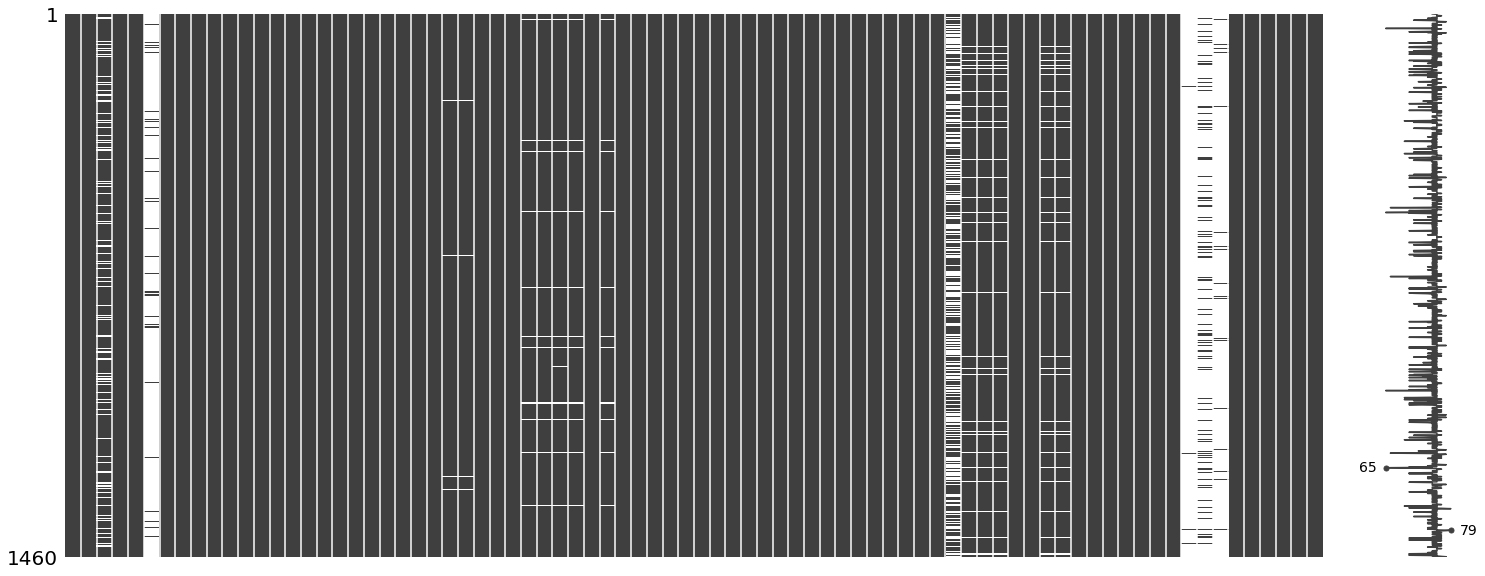

In [365]:
msno.matrix(train)
plt.show()

### **Treatment of missing values**

First we visualize those numerical features that have missing values

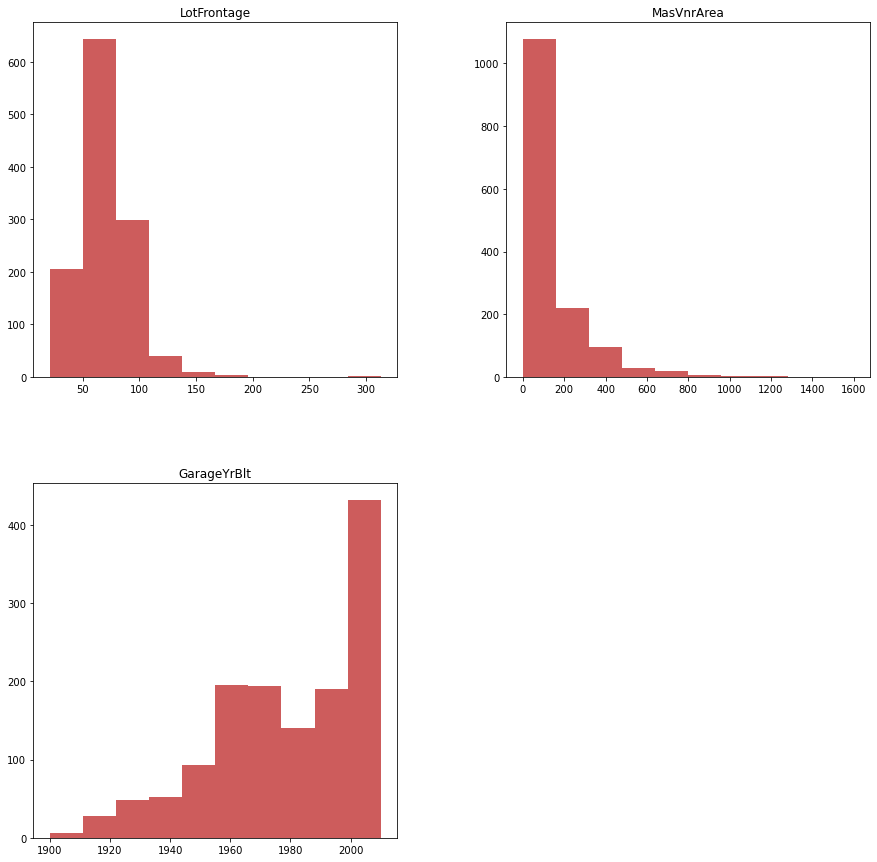

In [366]:
#Train 
train_NAN = train.loc[:,(train.isna().sum()>=1) & (train.dtypes!=object)]
train_NAN.hist(figsize = (15,15), facecolor='indianred',grid=False)
plt.show()

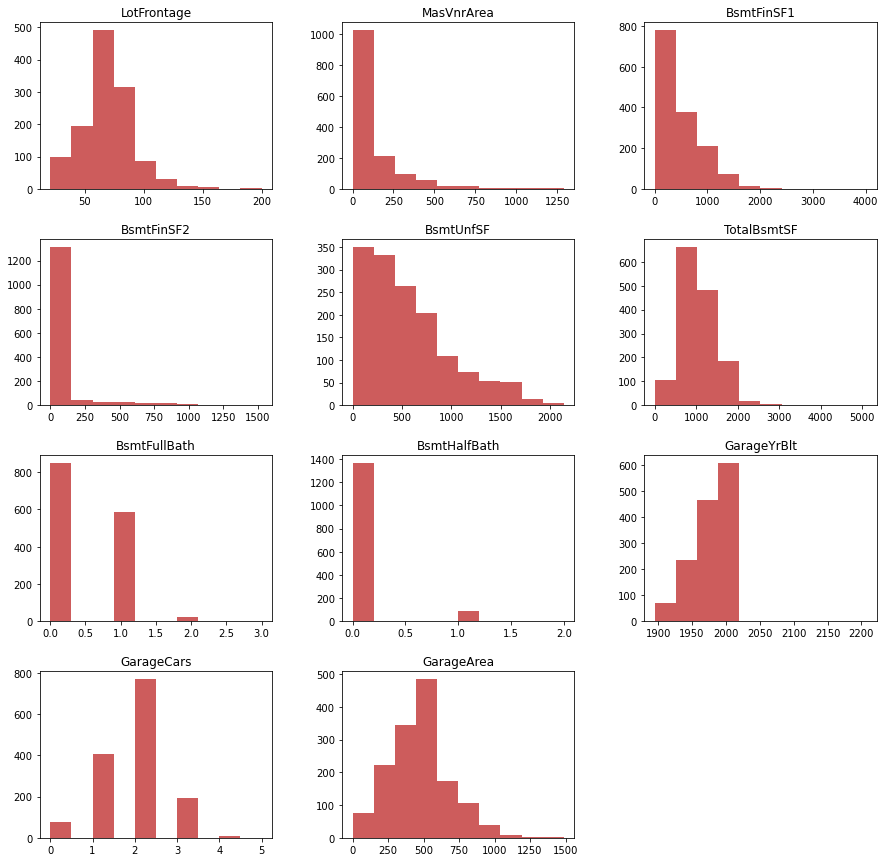

In [367]:
#Test
test_NAN = test.loc[:,(test.isna().sum()>=1) & (test.dtypes!=object)]
test_NAN.hist(figsize = (15,15), facecolor='indianred',grid=False)
plt.show()

First, we eliminate those variables that have more than 200 outliers, because in this way we would have to add less than 200 data per variable artificially, affecting our sample as little as possible.

In [370]:
drop_cols = train.loc[:,(train.isna().sum()>=200)].columns
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

For each variable that has missing values, we sample with replacement to fill in the missing values.

In [373]:
for i in range(train_NAN.shape[1]):
    col = train_NAN.columns[i]
    a = train_NAN[col]
    k =  a.isna().sum()
    sample = choices(a.dropna().tolist(), k=k)
    train[col] = a.fillna(pd.Series(sample, index = a[a.isna()].index.values))

In [374]:
for i in range(test_NAN.shape[1]):
    col = test_NAN.columns[i]
    a = test_NAN[col]
    k =  a.isna().sum()
    sample = choices(a.dropna().tolist(), k=k)
    test[col] = a.fillna(pd.Series(sample, index = a[a.isna()].index.values))

For categorical variables we define *NaN* as a new class. 

In [375]:
test = test.fillna("missing")
train = train.fillna("missing")

<AxesSubplot:>

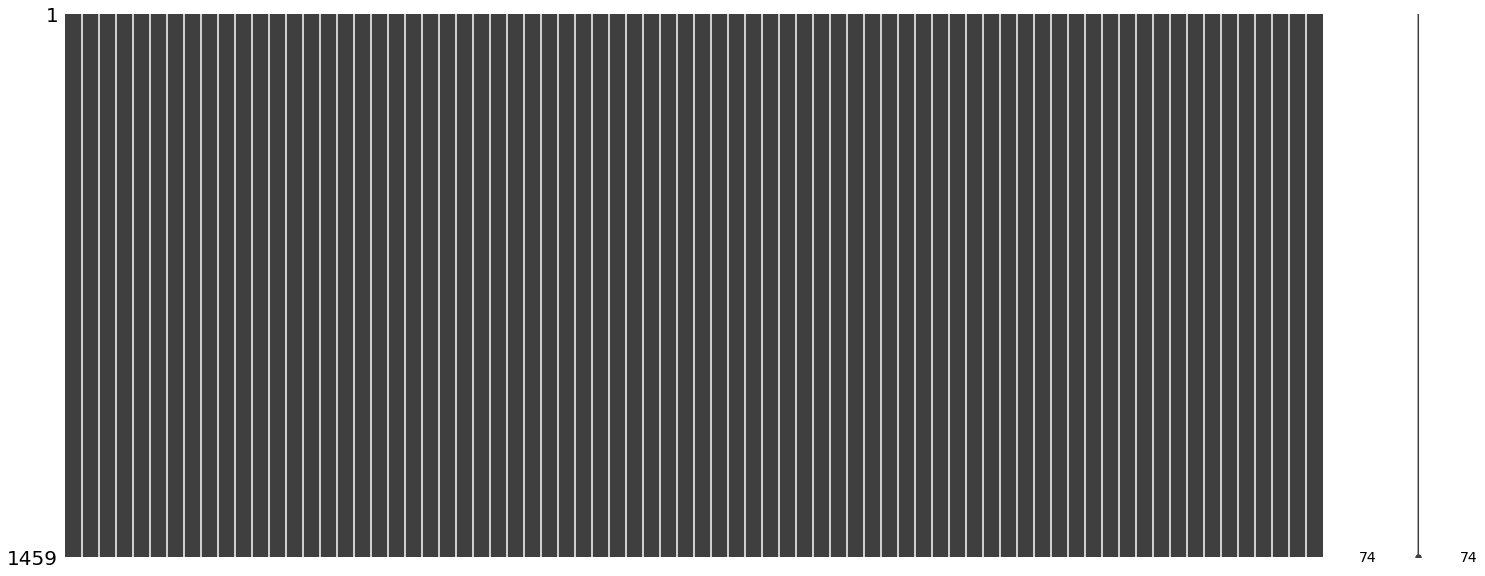

In [18]:
msno.matrix(test)

## Preprocessing

To make the evaluation of our models realistic, let's assume that we only know the training data. Therefore, the training set must be divided into a new training set and a new test set.

In [376]:
y = train['SalePrice']
X = train.drop(['SalePrice'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2)

### Categorical Data

For categorical features that we do not know if they follow any order, we define a function that performs a label encoding with dummy variables, in this way we can describe the information provided by each categorical variable without assuming an order that may be ambiguous.

In [377]:
def Dummies(X,X_train):
    cols_cat = (X_train.dtypes=='object').values
    X_cat= X_train.loc[:,cols_cat]
    X= X.loc[:,cols_cat]
    enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
    enc.fit(X_cat)
    names = enc.get_feature_names(X_cat.columns)
    return pd.DataFrame(enc.transform(X), columns = names)

This function takes two sets of data, the first is the one to be transformed and the second will give the information that we already know in order to fit the *OneHotEncoder* algorithm.  

In [378]:
X_dum_train = Dummies(X_train, X_train)
X_dum_test = Dummies(X_test, X_train)

In [379]:
print(X_dum_train.shape)
print(X_dum_test.shape)

(1168, 243)
(292, 243)


Taking a high value of $p$, we eliminate those variables that have a variance less than $ p (1-p) $, because this would indicate that the probability that any observation is  constant (0 or 1), is $ p \times100 \% $. We choose $ p = $ 0.95 for a high level of confidence.

In [380]:
no_cons = X_dum_train.var()>0.95*0.05    
X_dum_train = X_dum_train.loc[:,no_cons].reset_index(drop = True)
X_dum_test = X_dum_test.loc[:,no_cons].reset_index(drop = True)

In [381]:
X_dum_train.shape

(1168, 91)

**What if we only use categorical data to predict SalePrice?**

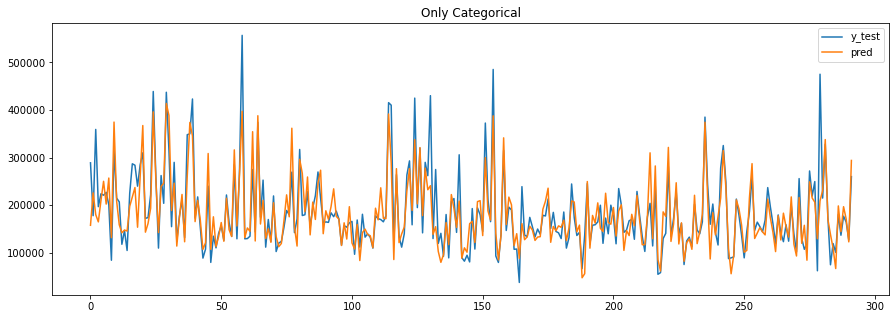

Test:
Root mean squared error: -42081.41015899037
R^2: 0.7325922490591315
AIC: 6400.059033208042
Train:
Root mean squared error: -39527.5991934641
R^2: 0.748946486835716
AIC: 6768.294535113023


LinearRegression()

In [382]:
Model_Eval(X_dum_train, X_dum_test, y_train, y_test, label = "Only Categorical")

### Numeric Data

We filter only the numeric variables for preprocessing

In [383]:
cols_num = (X_train.dtypes!='object').values
X_num_train  = X_train.loc[:,cols_num]
X_num_test = X_test.loc[:,cols_num]

In [384]:
X_num_train.shape

(1168, 36)

**What if we only use the numeric features without doing any preprocessing?**

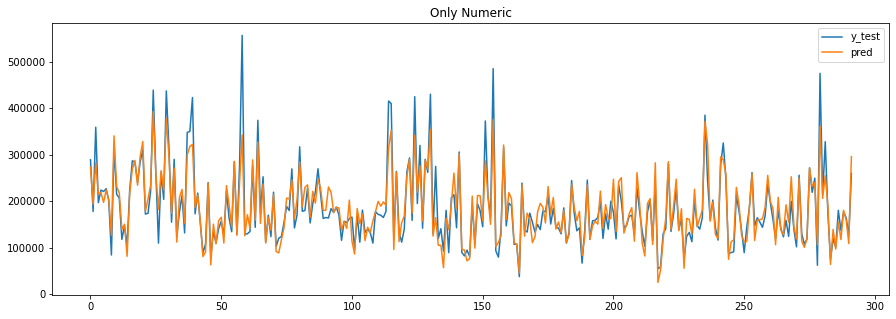

Test:
Root mean squared error: -31264.24858075596
R^2: 0.852398961837368
AIC: 6116.534615406491
Train:
Root mean squared error: -35237.81365263243
R^2: 0.8004814233737316
AIC: 6591.2049747549445


LinearRegression()

In [385]:
Model_Eval(X_num_train, X_num_test, y_train, y_test, label = "Only Numeric")

**Let's remove outliers**

Numerical variables or ordinal categorical variables are filtered, then the interquartile range is calculated for each variable as:
$$ IQR = Q_3-Q_1 $$
Where $ Q_3 $ and $ Q_1 $ are the third and first quartiles respectively. For each vairbale, the lower and upper limits are defined as those that bound the data that are not considered outliers. These limits follow the formulas:
$$ INF = Q_1 - 3IQR \hspace {2cm} SUP = Q_3 + 3IQR $$

Also, we eliminate those variables that have a considerable amount of outliers so as not to lose so many complete records. In addition, it was verified that the variables were not very significant in the model.

In [386]:
def rem_outliers(X_num_train, X_num_test, y_train, outliers_cond = True):
    data = X_num_train #pd.concat([X_num, y_train], axis = 1)
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
    INF=Q1-3*(IQR)
    SUP=Q3+3*(IQR)
    cols_o = pd.Series(data.columns)[(((data<INF)|(data>SUP)).sum()>=20).values]
    if(outliers_cond):
        wo = ~((data<INF)|(data>SUP)).drop(columns= cols_o).any(axis = 1).values #without outliers
    else: wo = np.ones(data.shape[0], dtype=bool)
    X_num_train = X_num_train.loc[wo].drop(columns= cols_o).reset_index(drop = True)
    X_num_test = X_num_test.drop(columns= cols_o).reset_index(drop = True)
    y_num_train = y_train[wo]
    return X_num_train, X_num_test, y_num_train, wo

In [387]:
X_train_wo, X_test_wo, y_train_wo, wo = rem_outliers(X_num_train, X_num_test, y_train)

In [388]:
X_train_wo.shape

(1129, 26)

**Scaling**

We define a function to scale the data through the MinMaxScaler algorithm, which sets the minimum value of the variable at zero and the maximum at one.

In [389]:
def scaler(X, sc = MinMaxScaler()):
    cols = X.columns
    scaler=sc
    x_scaled=scaler.fit_transform(X)
    return pd.DataFrame(x_scaled, columns= cols) , scaler

In [390]:
X_sc_train = scaler(X_train_wo)[0]
X_sc_test = pd.DataFrame(scaler(X_train_wo)[1].transform(X_test_wo), columns = X_sc_train.columns )
y_sc_train = scaler(pd.DataFrame(y_train_wo))[0]['SalePrice']

In [391]:
X_sc_train.shape

(1129, 26)

**Does the model improve by removing the outliers and scaling the data?**

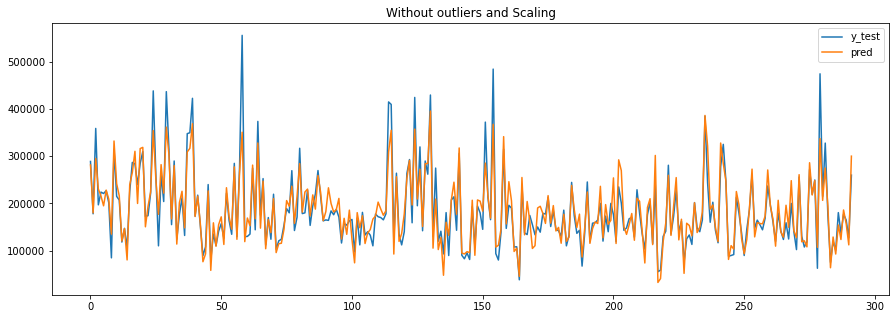

Test:
Root mean squared error: -31064.997249240325
R^2: 0.8542743299454852
AIC: 6092.8007927863755
Train:
Root mean squared error: -27959.71540062138
R^2: 0.8555264823411406
AIC: 6426.177148684265


LinearRegression()

In [392]:
Model_Eval(X_sc_train, X_sc_test, y_train_wo, y_test, label= "Without outliers and Scaling")

### A new data set

Let's concatenate numeric and categorical features

In [393]:
X_dum_train = X_dum_train.loc[wo].reset_index(drop = True)

In [394]:
X_new_train = pd.concat([X_sc_train, X_dum_train], axis = 1)
X_new_test = pd.concat([X_sc_test, X_dum_test], axis = 1)
y_new_train = y_train_wo

In [395]:
X_new_train.shape

(1129, 117)

## Feature Selection and Modeling

### Selecting Features by the correlation

First we remove autocorrelated variables with the criterion that if $\rho_{x_1, x_2}> = 0.8$ then one of the variables is eliminated

In [396]:
cor_matrix = X_new_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
X_new2_train = X_new_train.drop(columns = to_drop)
X_new2_test = X_new_test.drop(columns = to_drop)

We hold only the variables that have a correlation greater than 0.4 with the target variable

In [442]:
len(best)

20

Correlation of OverallQual with SalePrice: 0.7948560368434359


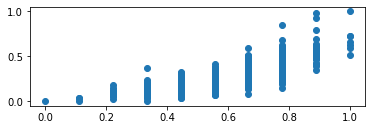

Correlation of YearBuilt with SalePrice: 0.5590358287207056


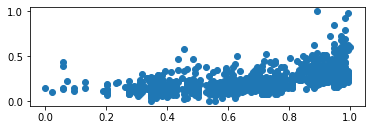

Correlation of YearRemodAdd with SalePrice: 0.5410588638130928


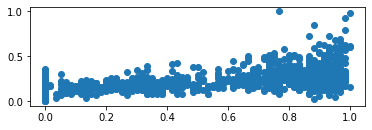

Correlation of BsmtFinSF1 with SalePrice: 0.40298841410168884


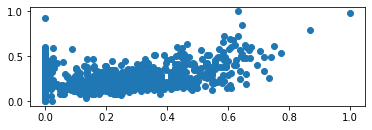

Correlation of TotalBsmtSF with SalePrice: 0.6444997464989085


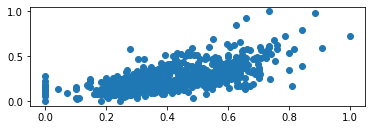

Correlation of 1stFlrSF with SalePrice: 0.6179005096432484


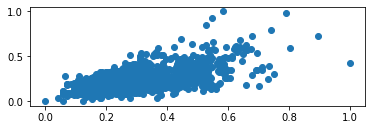

Correlation of GrLivArea with SalePrice: 0.7018508288217158


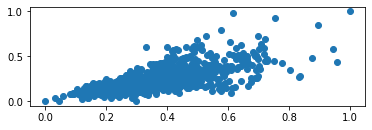

Correlation of FullBath with SalePrice: 0.5573343211159973


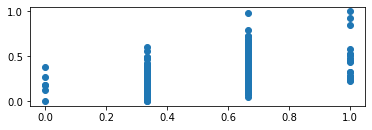

Correlation of Fireplaces with SalePrice: 0.4648438532262667


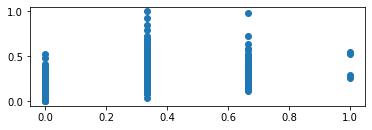

Correlation of GarageYrBlt with SalePrice: 0.4854882309968658


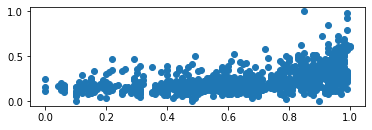

Correlation of GarageCars with SalePrice: 0.6444095765198763


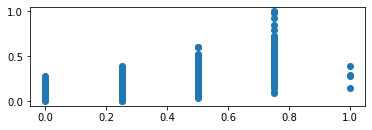

Correlation of ExterQual_Gd with SalePrice: 0.4707516084873209


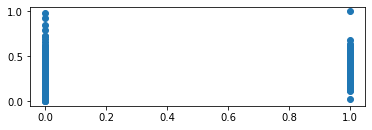

Correlation of Foundation_PConc with SalePrice: 0.5109284356652589


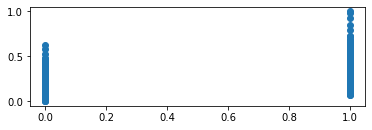

Correlation of BsmtQual_Ex with SalePrice: 0.5354699259444926


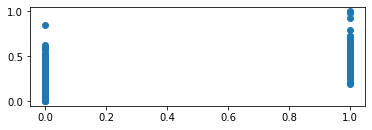

Correlation of BsmtQual_TA with SalePrice: -0.471233809696659


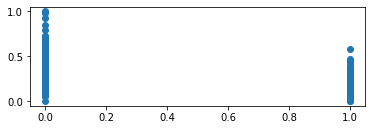

Correlation of BsmtFinType1_GLQ with SalePrice: 0.4355427824560581


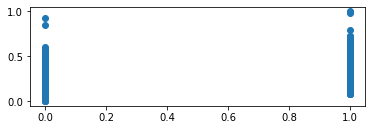

Correlation of HeatingQC_Ex with SalePrice: 0.46032132710234985


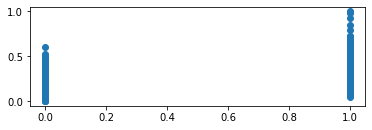

Correlation of KitchenQual_Ex with SalePrice: 0.4678558980894576


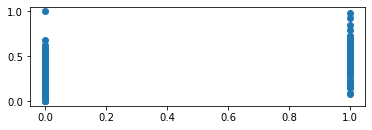

Correlation of GarageFinish_Fin with SalePrice: 0.4227410217002922


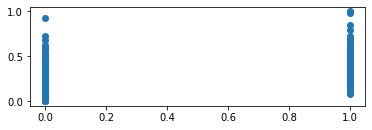

Correlation of GarageFinish_Unf with SalePrice: -0.43920053845582774


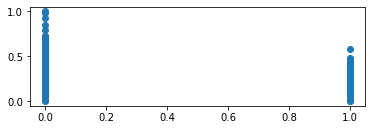

In [472]:
Xy_cor = pd.concat([X_new2_train, y_sc_train], axis=1, join='inner')
SaleP = Xy_cor.corr()['SalePrice']
Sale_cor_idx = SaleP.index[(abs(SaleP)>=0.4)]
best = Sale_cor_idx.drop('SalePrice')

for i in range(len(best)):
    plt.subplot(2,1,1)
    plt.scatter(X_new2_train.loc[:,best[i]], y_sc_train)
    print("Correlation of",best[i], "with SalePrice:", np.corrcoef(X_new2_train.loc[:,best[i]], y_sc_train)[1,0])
    plt.show()

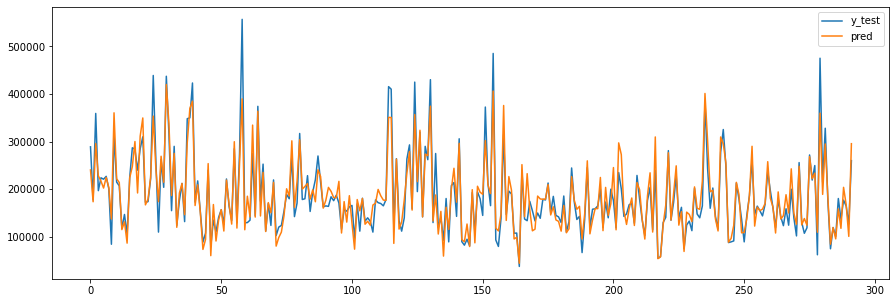

Test:
Root mean squared error: -29099.081644441456
R^2: 0.8721349101933412
AIC: 6042.621746125983
Train:
Root mean squared error: -27200.851630502155
R^2: 0.8632624615755008
AIC: 6398.107538524866


LinearRegression()

In [398]:
Model_Eval(X_new2_train[best], X_new2_test[best], y_new_train, y_test)

### Selecting Features with RFECV

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute such as the coefficients of the model. RFECV performs RFE in a cross-validation loop to find the optimal number of features.

In [399]:
def RFECV_selector(X_train, y_train, estimator,score_func):
    selector = RFECV(estimator, step=1, cv = 5, scoring = make_scorer(score_func))
    selector.fit(X_train, y_train)
    cols = pd.Series(X_train.columns)
    selected_features_rfe = cols.loc[selector.support_]
    score_cv = np.max(selector.cv_results_['mean_test_score'])
    print("Número óptimo de características: %d" % selector.n_features_)
    print("R^2 con el número óptimo de características: %f" % score_cv)
    
    cv_r = pd.DataFrame(selector.cv_results_['mean_test_score'], index = np.arange(0,len(cols))+1, columns = ['mean_R^2'])
    cv_r['lim_inf'] = selector.cv_results_['mean_test_score'] - 1.96*selector.cv_results_['std_test_score']
    cv_r['lim_sup'] = selector.cv_results_['mean_test_score'] + 1.96*selector.cv_results_['std_test_score']
    plt.figure(figsize=(7,4))
    plt.plot(cv_r.iloc[1:107,:])
    plt.axvline(x=selector.n_features_)
    plt.ylim(0.5,1)
    plt.title("R^2 Score")
    plt.show()
    return selector

Número óptimo de características: 43
R^2 con el número óptimo de características: 0.888446


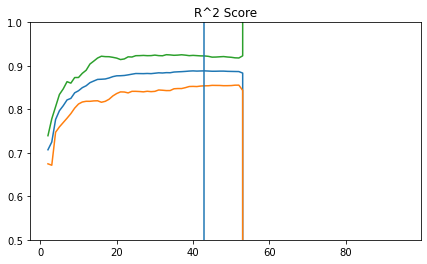

In [400]:
selector=RFECV_selector(X_new2_train, y_new_train, LinearRegression(), r2_score);

**Our best Feautures for this model**

In [401]:
X_best_train = pd.DataFrame(selector.transform(X_new2_train), columns = selector.get_feature_names_out())
X_best_test = pd.DataFrame(selector.transform(X_new2_test), columns = selector.get_feature_names_out())

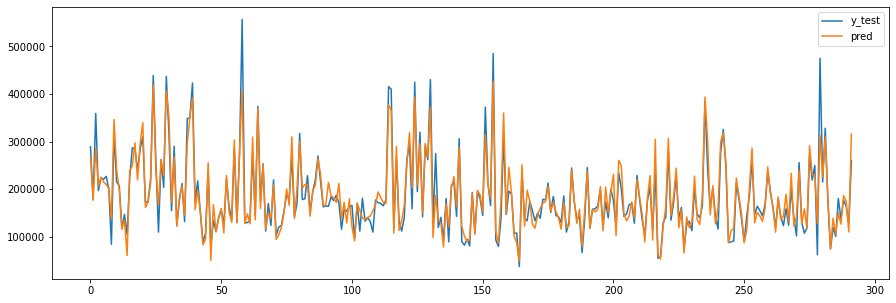

Test:
Root mean squared error: -26153.429760020554
R^2: 0.896711796795877
AIC: 6026.293600949187
Train:
Root mean squared error: -22353.979542631387
R^2: 0.9076509456671986
AIC: 6329.5010881069675


In [402]:
Model_Eval(X_best_train, X_best_test, y_new_train, y_test);

## Tuning hyperparameters

In [403]:
def tuning(X,y,estimator,parameters, score_func):
    Rsearch = RandomizedSearchCV(estimator, param_distributions=parameters, scoring = make_scorer(score_func) , cv = 5, n_iter = 5)
    Rsearch.fit(X,y)
    print("best parameters from train data: ", Rsearch.best_params_)
    print("best score from each iteration: ", Rsearch.best_score_)
    #y_pred = Rsearch.predict(X_test)
    return Rsearch
    

Let's define the possible hyperparameters

In [404]:
estimator = LinearRegression()
parameters = parameters = {'fit_intercept': [True, False], 'positive': [True, False]}

In [405]:
tun1 = tuning(X_best_train,y_new_train, estimator, parameters, r2_score)

best parameters from train data:  {'positive': False, 'fit_intercept': True}
best score from each iteration:  0.8956049902265457


## Evaluation 

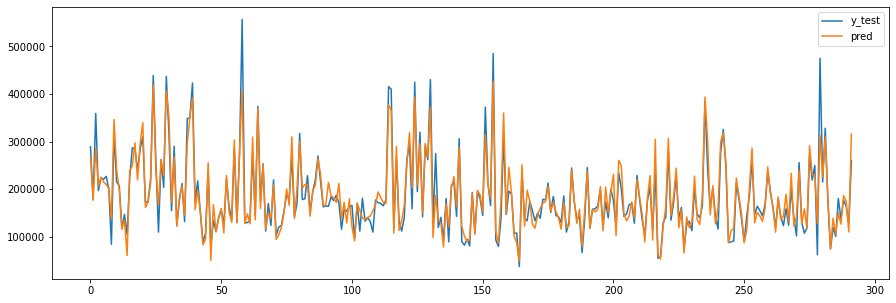

Test:
Root mean squared error: -26153.429760020554
R^2: 0.896711796795877
AIC: 6026.293600949187
Train:
Root mean squared error: -22353.979542631387
R^2: 0.9076509456671986
AIC: 6329.5010881069675


In [406]:
Model_Eval(X_best_train, X_best_test, y_new_train, y_test, tun1);

In [407]:
pred1 = tun1.predict(X_best_test)

## Trying with different models

In [408]:
def Bestfeatures(X_train = X, y_train = y, X_test = test, y_test = [0], estimator = LinearRegression()):
    
    X_dum_train = Dummies(X_train, X_train)
    X_dum_test = Dummies(X_test, X_train)
    #Categorical
    no_cons = X_dum_train.var()>0.95*0.05    
    X_dum_train = X_dum_train.loc[:,no_cons].reset_index(drop = True)
    X_dum_test = X_dum_test.loc[:,no_cons].reset_index(drop = True)
    if len(y_test)>1:
        Model_Eval(X_dum_train, X_dum_test, y_train, y_test, lm=estimator, label = "Only Categorical");
    #Numeric
    cols_num = (X_train.dtypes!='object').values
    X_num_train  = X_train.loc[:,cols_num]
    X_num_test = X_test.loc[:,cols_num]
    if len(y_test)>1:
        Model_Eval(X_num_train, X_num_test, y_train, y_test, lm=estimator,label = "Only Numeric");
    # Removing outliers
    X_train_wo, X_test_wo, y_train_wo, wo = rem_outliers(X_num_train, X_num_test, y_train)
    
    #Scaling
    X_sc_train = scaler(X_train_wo)[0]
    X_sc_test = pd.DataFrame(scaler(X_train_wo)[1].transform(X_test_wo), columns = X_sc_train.columns )
    y_sc_train = scaler(pd.DataFrame(y_train_wo))[0]['SalePrice']
    if len(y_test)>1:
        Model_Eval(X_sc_train, X_sc_test, y_train_wo, y_test, lm=estimator,label= "Without outliers and Scaling");
    # Joinnig
    X_dum_train = X_dum_train.loc[wo].reset_index(drop = True)
    X_new_train = pd.concat([X_sc_train, X_dum_train], axis = 1)
    X_new_test = pd.concat([X_sc_test, X_dum_test], axis = 1)
    y_new_train = y_train_wo
    
    cor_matrix = X_new_train.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    X_new2_train = X_new_train.drop(columns = to_drop)
    X_new2_test = X_new_test.drop(columns = to_drop)
    
    Xy_cor = pd.concat([X_new2_train, y_sc_train], axis=1, join='inner')
    SaleP = Xy_cor.corr()['SalePrice']
    Sale_cor_idx = SaleP.index[(abs(SaleP)>=0.4)]
    best = Sale_cor_idx.drop('SalePrice')
    if len(y_test)>1:
        Model_Eval(X_new2_train[best], X_new2_test[best], y_new_train, y_test, lm = estimator, label = "The most correlated features");
    
    # RFE 
    selector=RFECV_selector(X_new2_train, y_new_train, estimator, r2_score);
    
    X_best_train = pd.DataFrame(selector.transform(X_new2_train), columns = selector.get_feature_names_out())
    X_best_test = pd.DataFrame(selector.transform(X_new2_test), columns = selector.get_feature_names_out())
    
    if len(y_test)>1:
        Model_Eval(X_best_train, X_best_test, y_new_train, y_test, lm=estimator, label = "The Best Features" );
    
    return selector, X_best_test

### Lasso

In [409]:
estimator= LassoCV(alphas = [0.1,0.5,0.8,1,5,10])

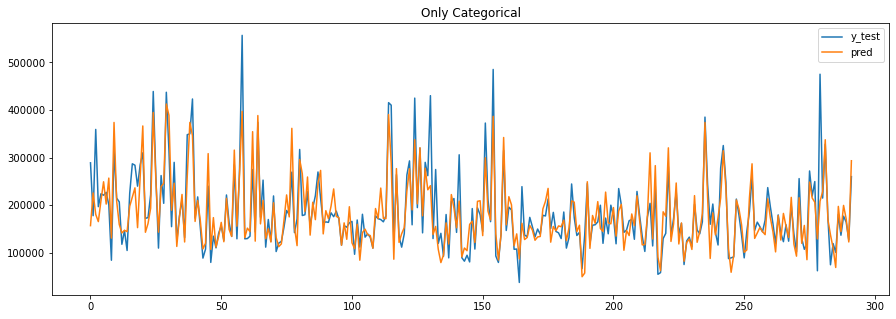

Test:
Root mean squared error: -42017.47170008471
R^2: 0.733404229948582
AIC: 6399.171029316197
Train:
Root mean squared error: -39541.39113191439
R^2: 0.7487712614873077
AIC: 6768.498268387054


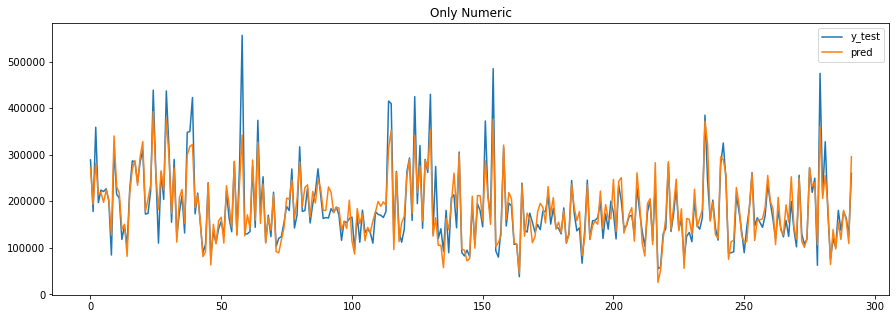

Test:
Root mean squared error: -31261.30349917102
R^2: 0.8524267684628257
AIC: 6116.479600213833
Train:
Root mean squared error: -35237.968537566405
R^2: 0.8004796694346372
AIC: 6591.20754167364


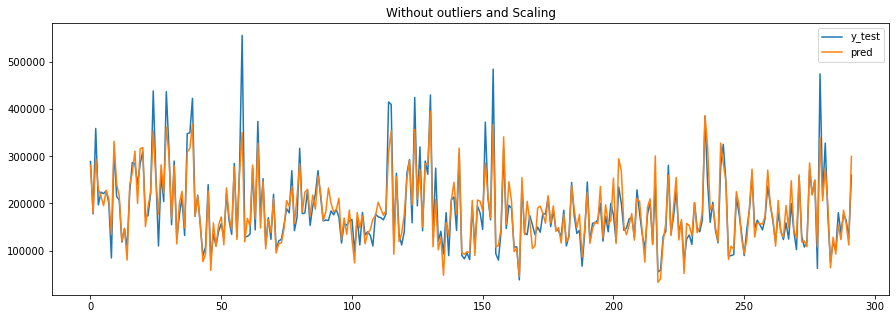

Test:
Root mean squared error: -31052.438893293616
R^2: 0.8543921284379052
AIC: 6092.5646568339525
Train:
Root mean squared error: -27963.09568279872
R^2: 0.8554915470228895
AIC: 6426.247749026262


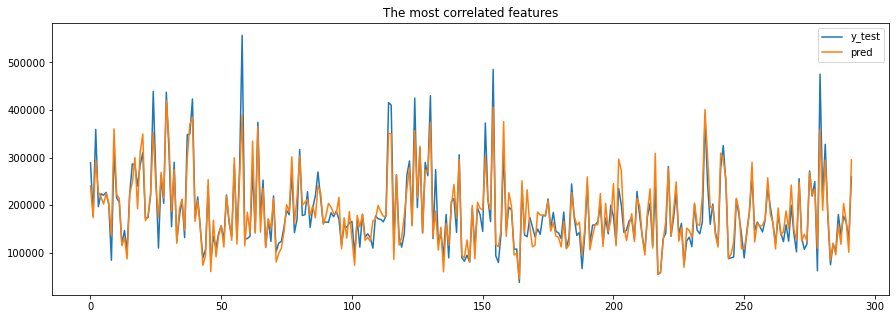

Test:
Root mean squared error: -29087.36020764987
R^2: 0.8722379004338673
AIC: 6042.386456977481
Train:
Root mean squared error: -27201.907757950907
R^2: 0.8632518431527313
AIC: 6398.130213052301
Número óptimo de características: 38
R^2 con el número óptimo de características: 0.889604


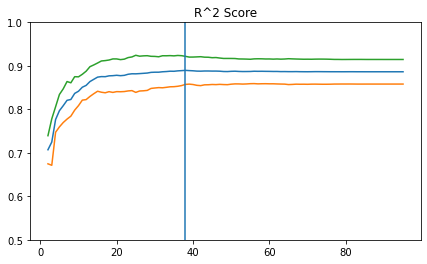

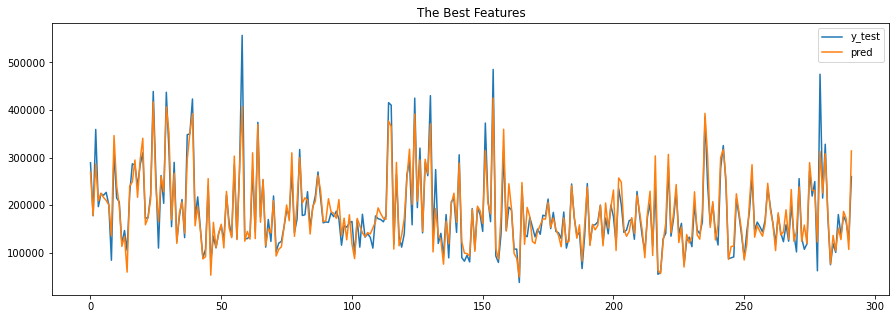

Test:
Root mean squared error: -26038.766565745962
R^2: 0.8976154941922757
AIC: 6013.7275693235915
Train:
Root mean squared error: -22457.19904257419
R^2: 0.9067961331529072
AIC: 6322.191501369088


In [410]:
Model2, X_test_final2 = Bestfeatures(X_train, y_train, X_test, y_test, estimator);

In [411]:
pred2 = Model2.estimator_.predict(X_test_final2)

### Ridge

In [412]:
estimator= RidgeCV(alphas = [0.1,0.5,0.8,1,5,10])

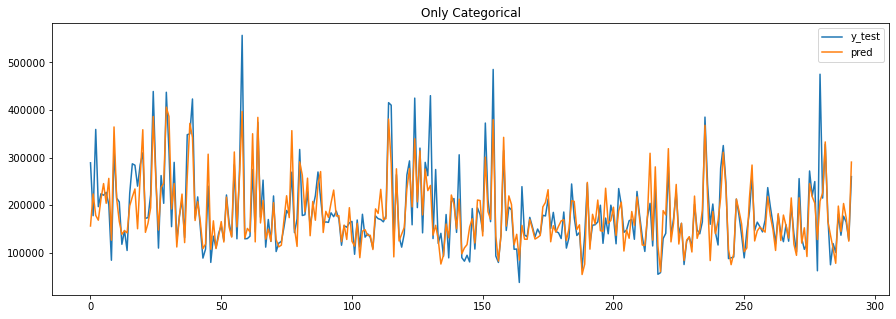

Test:
Root mean squared error: -41783.55211322605
R^2: 0.7363643500675074
AIC: 6395.910701761276
Train:
Root mean squared error: -39774.80359546574
R^2: 0.7457965055399463
AIC: 6771.93547998502


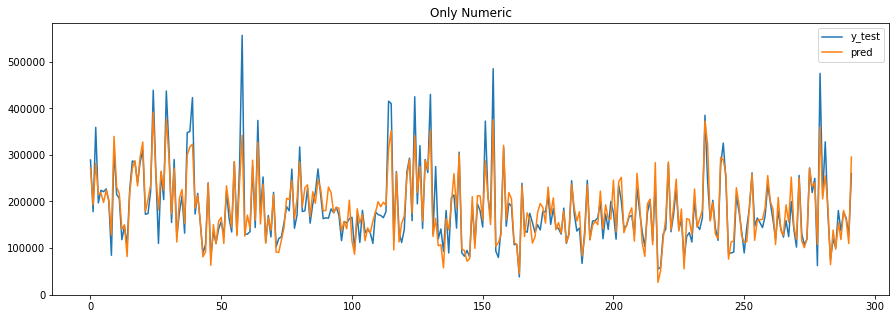

Test:
Root mean squared error: -31264.321831198064
R^2: 0.8523982701940721
AIC: 6116.535983685277
Train:
Root mean squared error: -35242.7927434716
R^2: 0.8004250355789639
AIC: 6591.287487922852


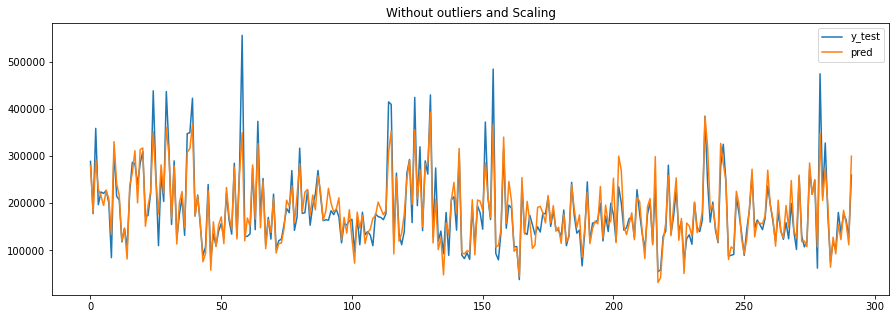

Test:
Root mean squared error: -31000.448037746653
R^2: 0.8548793005028378
AIC: 6091.586050736933
Train:
Root mean squared error: -27993.779825825648
R^2: 0.855174232310111
AIC: 6426.888225863503


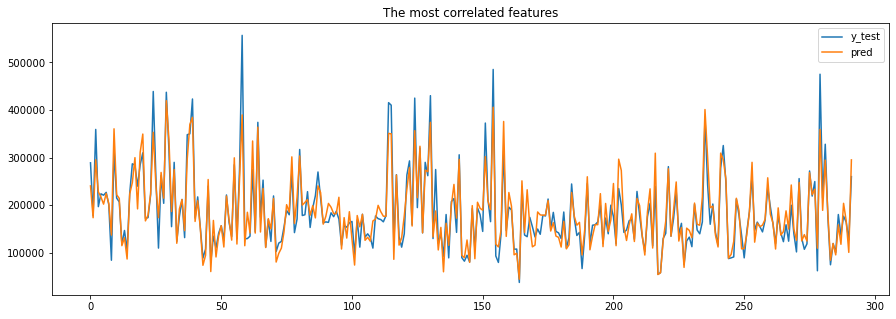

Test:
Root mean squared error: -29115.942615671018
R^2: 0.871986688731555
AIC: 6042.960037060277
Train:
Root mean squared error: -27201.510001959716
R^2: 0.8632558422840776
AIC: 6398.121673533704
Número óptimo de características: 38
R^2 con el número óptimo de características: 0.888684


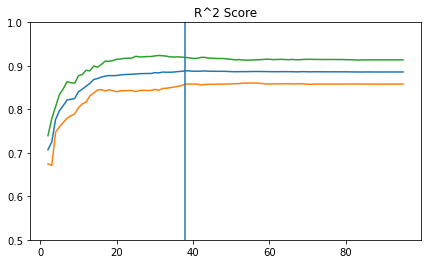

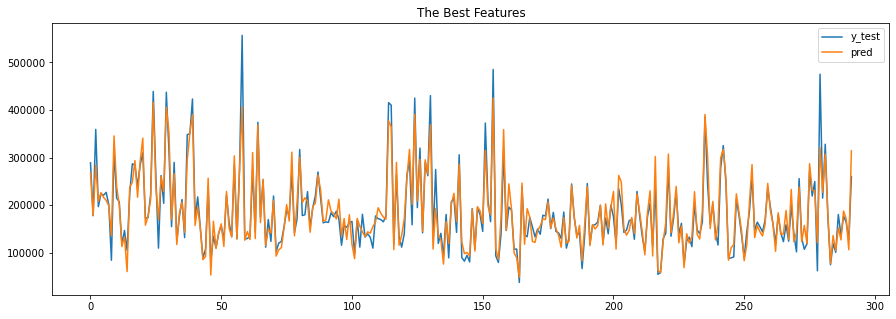

Test:
Root mean squared error: -25846.9513974125
R^2: 0.8991183738282811
AIC: 6009.409596169089
Train:
Root mean squared error: -22484.75513743287
R^2: 0.9065672613040179
AIC: 6322.907658986521


In [413]:
Model3, X_test_final3 = Bestfeatures(X_train, y_train, X_test, y_test, estimator);

In [414]:
pred3 = Model3.estimator_.predict(X_test_final3)

### ElasticNet

This algorith minimizes the function
$$ 1 / (2 * n_{samples}) * ||y - Xw||^2_2
+ \alpha * l1_{ratio} * ||w||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||w||^2_2 $$

In [415]:
estimator= ElasticNetCV(l1_ratio = [.1,0.2, .5, .7, .9,.95, .99, 1], alphas = [0.1,.5, 1, 5, 10])

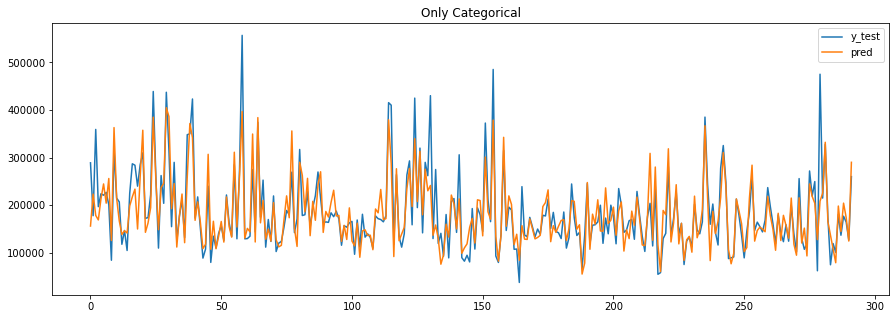

Test:
Root mean squared error: -41771.321947551085
R^2: 0.7365186613039341
AIC: 6395.739738262486
Train:
Root mean squared error: -39827.78183915821
R^2: 0.7451188793873784
AIC: 6772.712824055329


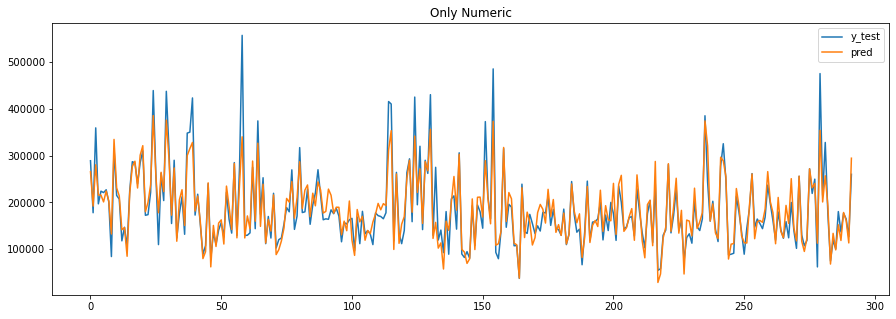

Test:
Root mean squared error: -31308.156587726087
R^2: 0.8519840842296607
AIC: 6117.354218878991
Train:
Root mean squared error: -35383.43449132806
R^2: 0.7988289885238408
AIC: 6593.613391274407


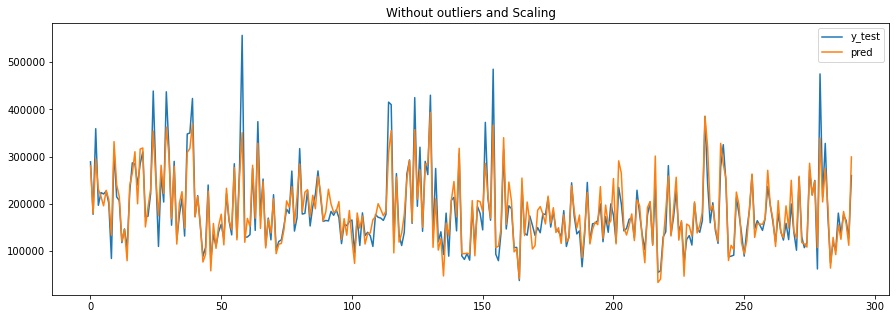

Test:
Root mean squared error: -30937.94436727205
R^2: 0.8554639005859308
AIC: 6090.407390635168
Train:
Root mean squared error: -27976.06995513003
R^2: 0.8551768209711227
AIC: 6427.035463863619


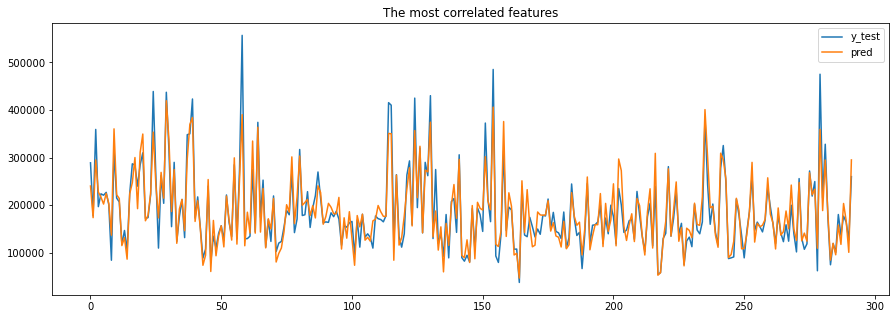

Test:
Root mean squared error: -29094.841395215397
R^2: 0.8721721718741142
AIC: 6042.536640828967
Train:
Root mean squared error: -27184.765949612927
R^2: 0.8632536124160479
AIC: 6398.278892444391
Número óptimo de características: 38
R^2 con el número óptimo de características: 0.888992


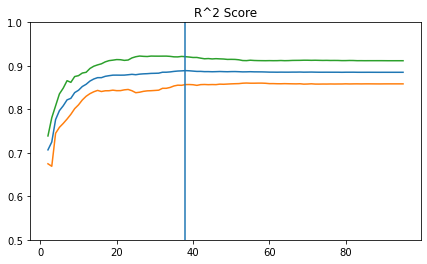

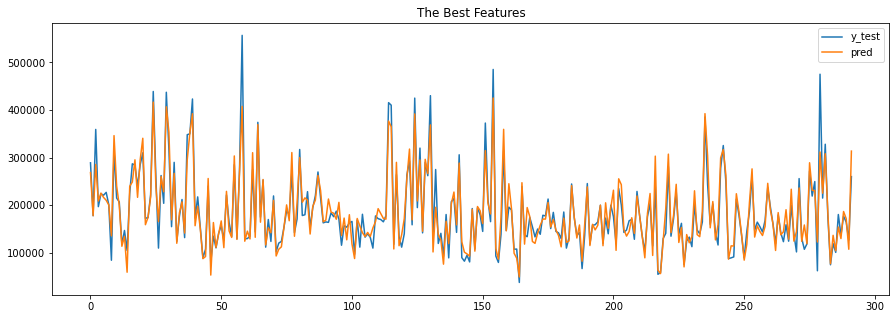

Test:
Root mean squared error: -25996.259597889395
R^2: 0.897949496391019
AIC: 6012.773439900385
Train:
Root mean squared error: -22456.761870077065
R^2: 0.9066833942664185
AIC: 6322.696946871358


In [315]:
Model4, X_test_final4 = Bestfeatures(X_train, y_train, X_test, y_test, estimator);

In [316]:
pred4 = Model4.estimator_.predict(X_test_final4)

### Gradient Boosting Regressor

Machine learning boosting is a method for creating an ensemble. It starts by fitting an initial model (e.g. a tree or linear regression) to the data. Then a second model is built that focuses on accurately predicting the cases where the first model performs poorly. The combination of these two models is expected to be better than either model alone. Then you repeat this process of boosting many times.  

In [419]:
estimator= GradientBoostingRegressor(init = LinearRegression())

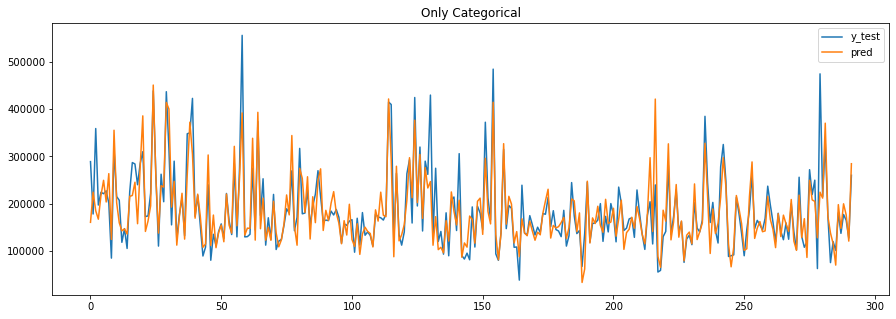

Test:
Root mean squared error: -42244.47469194813
R^2: 0.7305158355780308
AIC: 6402.31764706345
Train:
Root mean squared error: -29470.116733661125
R^2: 0.8604502248689982
AIC: 6596.819062953037


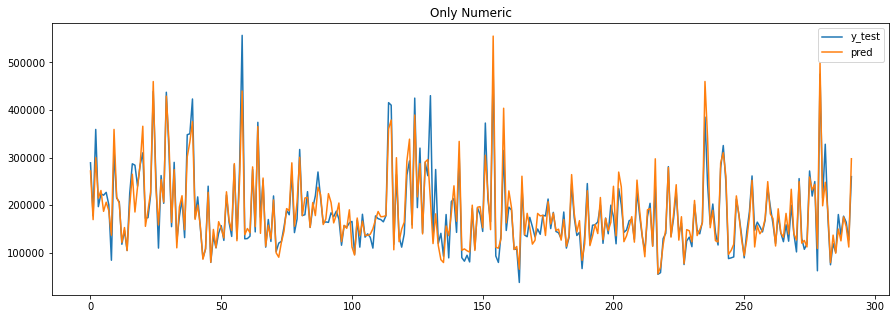

Test:
Root mean squared error: -28706.244495747083
R^2: 0.875563960273785
AIC: 6066.684054496735
Train:
Root mean squared error: -15806.55234729348
R^2: 0.959854235131956
AIC: 6123.0149791738695


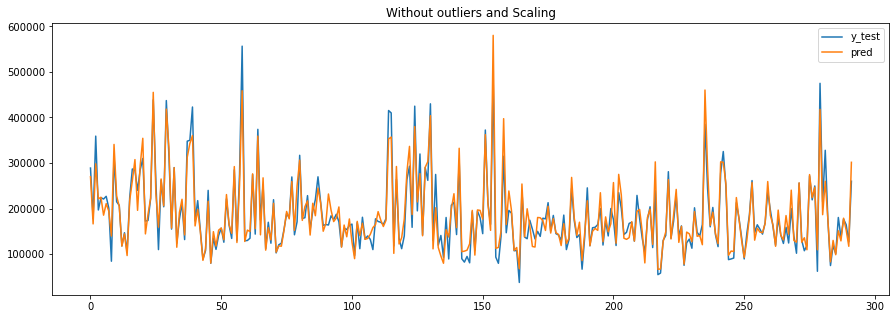

Test:
Root mean squared error: -25262.324150500015
R^2: 0.9036304061188474
AIC: 5972.048530065449
Train:
Root mean squared error: -15597.254338879251
R^2: 0.9550407495196571
AIC: 6085.313959985571


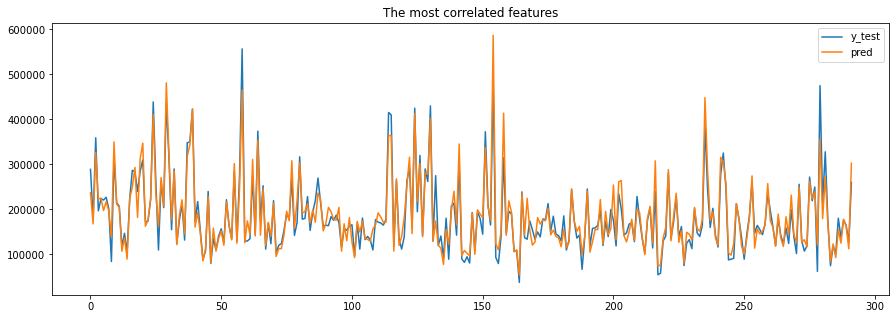

Test:
Root mean squared error: -25892.587782446724
R^2: 0.8987618182676199
AIC: 5974.439820102046
Train:
Root mean squared error: -16843.60814177235
R^2: 0.9475684118458091
AIC: 6118.209749096308
Número óptimo de características: 76
R^2 con el número óptimo de características: 0.903151


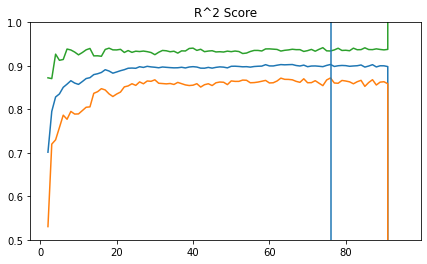

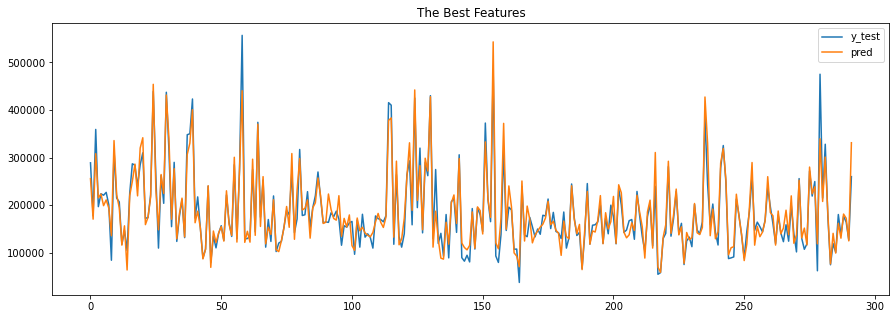

Test:
Root mean squared error: -24380.050293929224
R^2: 0.910244180544237
AIC: 6051.287952115184
Train:
Root mean squared error: -14219.561824496484
R^2: 0.9626324020221039
AIC: 6131.307809559332


In [420]:
Model5, X_test_final5 = Bestfeatures(X_train, y_train, X_test, y_test, estimator);

In [319]:
pred5 = Model5.estimator_.predict(X_test_final5)

## Final comparison

In [327]:
Comp_Eval = pd.DataFrame(y_test).reset_index(drop = True)

In [328]:
Comp_Eval['Pred1'] = pred1
Comp_Eval['Pred2'] = pred2
Comp_Eval['Pred3'] = pred3
Comp_Eval['Pred4'] = pred4
Comp_Eval['Pred5'] = pred5

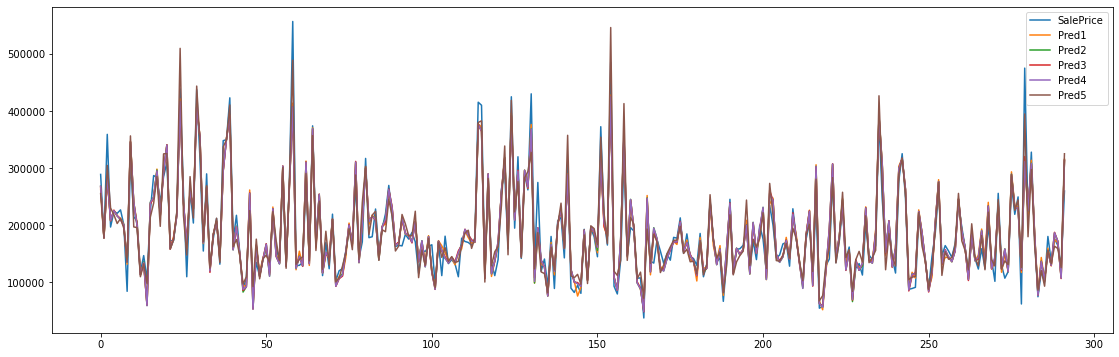

In [353]:
Comp_Eval.plot(figsize = (19,6))
plt.show()

In [416]:
lab = ['Linear Regression------', 'Lasso------', 'Ridge-----', 'Elastic Net-----', 'Gradient Boosting-----']
for i in range(5):
    print(lab[i])
    print("RMSEL:", RMSEL(Comp_Eval['SalePrice'], Comp_Eval.iloc[:,(i+1)]))
    print("r2:", r2_score(Comp_Eval['SalePrice'], Comp_Eval.iloc[:,(i+1)]))

Linear Regression------
RMSEL: 0.13759402583309024
r2: 0.9026027917408275
Lasso------
RMSEL: 0.14054869811152793
r2: 0.898420736583127
Ridge-----
RMSEL: 0.1394997089115172
r2: 0.8994805489428591
Elastic Net-----
RMSEL: 0.14100836851906035
r2: 0.897949496391019
Gradient Boosting-----
RMSEL: 0.13551873223094482
r2: 0.91141202000355


It is clear that the best models are the linear regression model without regularization and the Gradient Boosting Regressor

## Model with the original train set  and prediction with the original test set

In [421]:
estimator = GradientBoostingRegressor(init = LinearRegression())

Número óptimo de características: 45
R^2 con el número óptimo de características: 0.911517


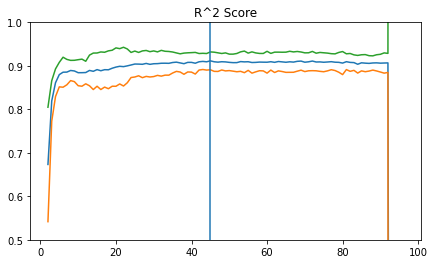

In [422]:
Model, X_test_final = Bestfeatures(X, y, test, [0], estimator);

Let's visualize what the test set looks like after preprocessing

In [473]:
X_test_final.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,...,BsmtFinType1_GLQ,CentralAir_N,KitchenQual_Ex,KitchenQual_Gd,Functional_Typ,GarageType_Attchd,GarageType_missing,GarageFinish_RFn,SaleType_New,SaleType_WD
0,0.000000,0.444444,0.571429,0.644928,0.183333,0.213894,0.115582,0.334979,0.000000,0.170665,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.555556,0.571429,0.623188,0.133333,0.421846,0.173801,0.504747,0.000000,0.302156,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.235294,0.444444,0.428571,0.905797,0.800000,0.361517,0.058647,0.352450,0.385589,0.393258,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.235294,0.555556,0.571429,0.913043,0.800000,0.275137,0.138699,0.351690,0.372937,0.385667,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.588235,0.777778,0.428571,0.869565,0.700000,0.120201,0.435360,0.486137,0.000000,0.287276,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [481]:
pd.DataFrame(X_test_final.columns.values, columns = ['Features Selected'])

,Features Selected
0,MSSubClass
1,OverallQual
2,OverallCond
3,YearBuilt
4,YearRemodAdd
5,BsmtFinSF1
6,BsmtUnfSF
7,TotalBsmtSF
8,2ndFlrSF
9,GrLivArea


Our Prediction

In [423]:
pred = Model.estimator_.predict(X_test_final)
pd.DataFrame(pred, index = test.index, columns = ['SalePrice'])

,SalePrice
Id,
1461,124541.730702
1462,165106.113898
1463,181382.274483
1464,191422.129067
1465,168796.652052
...,...
2915,90140.169613
2916,88697.125063
2917,174211.573330


In [424]:
#pd.DataFrame(pred, index = test.index, columns = ['SalePrice']).to_csv('SalePrice2.csv')